# Решение задачи распознования рукописных цифр

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

Прочитаем данные из папки input

In [2]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


В данной задаче в качестве исходных данных имеем набор из "42 тысячи картинок рукописных цифр". 

Чтобы была возможность с этими картинками работать (обучать модель компьютерного зрения) эти картинки перевели в двоичный вид, где 1 - это закрашенный пиксель, а 0 - это незакрашенный пиксель картинки (если цифры черные, а фон белый) или 0 - черный пиксель, а 1 белый пиксель (если цифры белые, а фон черный) 

Таким образом, на входе имеем помеченный датасет из 42 000 строк и 785 столбцов (784 - это количество пикселей каждой картинки (28х28=784 пикселей) + 1 столбик (столбик 'labels') - это метки данных). Помеченный датасет означает, что для каждой картинки, записанной в двоичном коде мы имеем правильный ответ, в данном конкретном примере это цифры от 0 до 9 вкл.

Обозначим X (аргументы искомой функции - данные, на которых будем обучать модель) и y - помеченные ответы (значения функции)

In [4]:
y_train = train_data['label'].values  # Берем значения столбца ответов
X_train = train_data.drop(columns=['label']).values/255  # Преобразуем тренировочные данные. Удаляем из исходного dataFrame колонку label
X_test = test_data.values/255  # Преобразуем тестовые данные, разделив значения каждой ячейки на 255

In [5]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Рассмотрим входные данные.
Случайно выберем 10 примеров из тренировочного датасета и визуализируем их

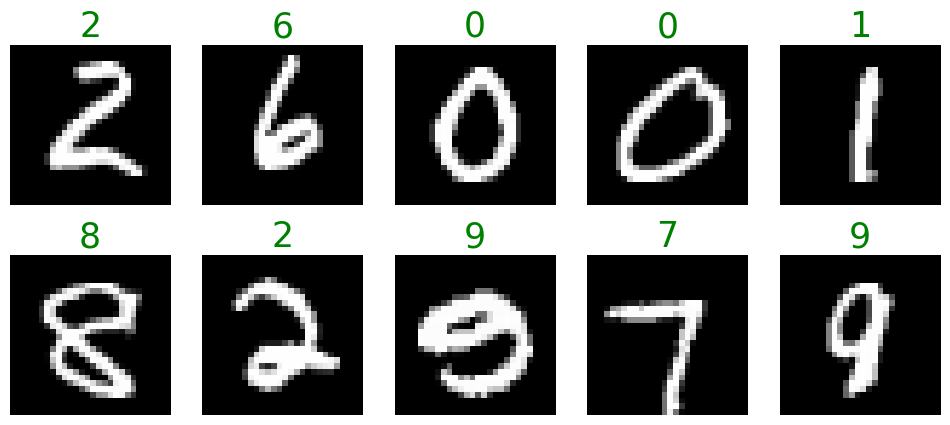

In [6]:
# Задаем параметры выводимого графика:
fig, axes = plt.subplots(2,5, figsize=(12,5)) 
axes = axes.flatten()
# Выбираем случайные цифры из тестового датасета, содержащего 42000 рукописных цифр 
# (запись последовательности цифр окрашенных (1) и неокрашенных пикселей (0))
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')  # задаем цвет/формат изображений
    axes[i].axis('off') # скрываем отметки осей
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'green', fontsize=25)  # задаем подписи над изображениями цифр
plt.show()  # Вывод на дисплей 

Создадим нейросеть из 3 слоёв. 

1-ый слой будет содержать 28х28=784 нейрона (по числу пикселей в картинках 28х28 (ну или из длин списков каждой строки в заданном датасете))

2-ой слой скрытый 256

3-ий слой состоит из одного выходного нейрона 

Создаём функцию активации нейронов следующих слоев

# Структура сети

In [7]:
def relu(x):
    x[x<0]=0
    return x

In [8]:
def h(X,W,b):
    '''
    Функция реализующая нейросеть из трех слоёв
    '''
    # Первый входной слой
    a1 = X
    # Переход от первого слоя ко второму
    z1 = np.matmul(X, W[0]) + b[0] # Находим произведение векторов (матриц их координат) и прибавляем смещение слоя

    # Второй слой, создаем путем активации (весов нейронов предыдущего слоя + смещение слоя) с помощью функции активации relu
    a2 = relu(z1)
    # Переход от втоорго слоя к третьему
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    # Выводим вероятность для каждого просматриваемого изображения (строки из датасета где указаны "активности" пикселей)
    return sigma

In [10]:
def loss(y_pred,y_true):
    '''
    Создаем функцию отклонения (величина ошибки), 
    которая будет выводить процент отклонения предсказанного значения от истинного

    y_true: правильные ответы, формой (N, )
    y_pred: предсказания, сделанные моделью по форме (N, K) 
    N: величина пакета (batch size)
    K: global variable, number of classes
    '''
    global K # Создаем глобальную переменную число классов от 0...9
    K = 10
    N = len(y_true)  # величина пакета (batch size)
    # Переводим y_true из колонки labels в одномерный вектор
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    # Сохраняем перекрестную энтропию для каждого образца (изображения)
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1) 
    # loss_sample представляет из себя одномерный массив 
    # для подсчета итогового отклонения (final loss), нам нужно взять среднее значение отклонений
    return -np.mean(loss_sample)

# Создаем функцию обратного распространения ошибки

In [11]:
def backprop(W,b,X,y,alpha=1e-4):
    '''
    Шаг 1: Проходим вперед и вычисляем по нейросети и получаем какие-то результаты на выходе.
    В зависимости от полученных результатов делаем вывод насколько далеко мы от правильного решения.
    Шаг 2: Проходим назад по сети и беря производные от функции ошибки и выясняя те значения весов и 
    смещений, которые соответствуют наименьшим значениям функции ошибки.
    Как понять в каком направлении изменять веса (влияние) и смещения между слоями? 
    Для этого необходимо вычислить обратный градиент функции! (вектор с направлением наискорейшего 
    возрастания функции, длина вектора равна мгновенной величине возрастания значения функции в точке, 
    а координаты этого вектора есть частные производные функции в точке)
    '''
    K = 10
    N = X.shape[0]
    
    ## Шаг 1:
    # Первый слой:
    a1 = X
    # Записываем переход от первого слоя ко второму
    z1 = np.matmul(X, W[0]) + b[0]
    # Активация нейронов второго слоя
    a2 = relu(z1)
    
    # Переход от второго слоя к третьему
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    # Вычисляем вероятность того что полученные данные (координаты вектора) правильно 
    # интерпретируем, например как число 1 или 2 ...
    sigma = s/total 
    
    ### Шаг 2:
    
    # Производные весов при переходе от второго слоя к третьему
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)
    
    # Производные весов при переходе от второго слоя к третьему
    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)
    
    # Нет производных для первого слоя, т. к. он входной
    # alpha регуляризация производной
    
    # Производные весов между нейронами разных соседних слоев
    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]  
    # Производные смещения между слоями
    db = [np.mean(delta1, axis=0)]  
    return dW, db

# Параметры сети и инициализация нейросети

In [12]:
eta = 5e-1
alpha = 1e-6 # регуляризация
gamma = 0.99 
eps = 1e-3 
num_iter = 1000 # число итераций градиентного спуска
n_H = 256 # число нейронов скрытого слоя
n = X_train.shape[1] # число пикселей в картинках
K = 10

In [13]:
# Подбираем случайное зерно такое, при котором у нас получаются наилучшие значения score
np.random.seed(1127825)
# Создаем вектор весов как случайные числа из нормального распределения со средним в указанном значении
W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)]
# Создаем смещения как случайное число из нормального распределения со средним в указанном значении
b = [np.random.randn(n_H)]

# Градиентный спуск (обучение нейросети)

In [14]:
%%time
gW0 = gW1 = gb0 = 1 # Зададим изначальные значения производных весов и смещений

for i in range(num_iter):
    dW, db = backprop(W,b,X_train,y_train,alpha)  # Производные векторов весов и смещений
    
    gW0 = gamma*gW0 + (1-gamma)*np.sum(dW[0]**2)
    etaW0 = eta/np.sqrt(gW0 + eps)
    W[0] -= etaW0 * dW[0]
    
    gW1 = gamma*gW1 + (1-gamma)*np.sum(dW[1]**2)
    etaW1 = eta/np.sqrt(gW1 + eps)
    W[1] -= etaW1 * dW[1]
    
    gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
    etab0 = eta/np.sqrt(gb0 + eps)
    b[0] -= etab0 * db[0]
    
    if i % 500 == 0:
        # Чтобы видеть процесс обучения. Для каждой 500-ой эпохи выводим значения
        y_pred = h(X_train,W,b)
        print("Значение перекрестной энтропии после", i+1, "проходки {:.8}".format(
              loss(y_pred,y_train)))
        print("Точность предсказания на тренировочном датасете после", i+1, "проходки {:.4%}".format( 
              np.mean(np.argmax(y_pred, axis=1)== y_train)))
        print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
              .format(gW0, gW1, gb0, etaW0, etaW1, etab0))
        print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}"
             .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")
        gW0 = gW1 = gb0 = 1

y_pred_final = h(X_train,W,b)
print("Финальное значение потерь составило {:.8}".format(loss(y_pred_final,y_train)))
print("Финальное значение точности предсказания {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_train)))

Значение перекрестной энтропии после 1 проходки 7.6743264
Точность предсказания на тренировочном датасете после 1 проходки 24.9262%
gW0=1.0839 gW1=1.3825 gb0=0.9923
etaW0=0.4800 etaW1=0.4251 etab0=0.5017
|dW0|=3.06418 |dW1|=6.26530 |db0|=0.48001 

Значение перекрестной энтропии после 501 проходки 0.13586252
Точность предсказания на тренировочном датасете после 501 проходки 96.1429%
gW0=0.3495 gW1=0.1121 gb0=0.0153
etaW0=0.8446 etaW1=1.4870 etab0=3.9189
|dW0|=0.05204 |dW1|=0.02360 |db0|=0.00697 

Финальное значение потерь составило 0.062031888
Финальное значение точности предсказания 98.1762%
CPU times: user 51min 22s, sys: 9min 58s, total: 1h 1min 21s
Wall time: 16min 15s


# Предсказания для тестового dataset

In [15]:
y_pred_test = np.argmax(h(X_test,W,b), axis=1)

In [16]:
# Создадим предсказанание записав в файл csv
submission = pd.DataFrame({'ImageId': range(1,len(X_test)+1) ,'Label': y_pred_test })
submission.to_csv("simpleMNIST_fin_result.csv",index=False)